In [1]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')
# !cp "/content/drive/MyDrive/AI芒果辨識競賽/C1-P1_Train Dev.rar" "/content/"

In [1]:
# !mkdir "mango"
# !unrar x "C1-P1_Train Dev.rar" "mango"

In [1]:
DATA_DIR = 'data/mango'

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import shutil
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b3, efficientnet_b0, efficientnet_b6
import torch
from torch.utils.data import Dataset
from torch.nn import ZeroPad2d
import matplotlib.pyplot as plt
import tensorflow as tf
import timm

PADDING_SIZE = 1536
IMG_SHAPE = (224, 224)
# BATCH_SIZE = 512
OUTPUT_CLASSES = 3
MEAN = [55.49694383, 60.2820865, 82.53554147]
STD = [65.72940478, 67.66902771, 87.42390442]
dtype = torch.float32

In [3]:
class History:
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []
        self.running_loss = 0
        self.running_acc = 0
        
    def batch_train(self, batch_loss, batch_acc):
        self.running_loss += batch_loss
        self.running_acc += batch_acc
        
    def epoch_train(self, batch_num):
        self.train_loss.append(self.running_loss / batch_num)
        self.train_acc.append(self.running_acc / batch_num)
        self.running_loss = 0
        self.running_acc = 0
        
    def epoch_val(self, val_loss, val_acc):
        self.val_loss.append(val_loss)
        self.val_acc.append(val_acc)


def calculate_accuracy(y_pred, y_true):
    # y_pred y_true要是2D array (每筆資料的label的onehot encoding)
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    correct = (y_pred == y_true).float().sum()
    accuracy = correct / len(y_true)
    return float(accuracy)

def validation(model, loader):
    num_correct = 0
    num_samples = 0
    loss = 0.0
    all_y_true = []
    all_y_pred = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y_true = y.to(device=device, dtype=dtype).argmax(axis=1)
            scores = model(x)
            _, preds = scores.max(1)
            num = preds.size(0)
            loss += CE_loss(scores, y_true) * num
            
            all_y_true.append(y_true)
            all_y_pred.append(preds)

            num_correct += (preds == y_true).sum()
            num_samples += num
    acc = float(num_correct) / num_samples
    loss = float(loss / num_samples)
    return acc, loss, (all_y_true, all_y_pred)

In [4]:
def read_data(which="train"):
    data_dir = None
    y = None
    if which == "train":
        data_dir = os.path.join(DATA_DIR, "C1-P1_Train")
        label_csv = os.path.join(DATA_DIR, "train.csv")
    elif which == "test":
        data_dir = os.path.join(DATA_DIR, "C1-P1_Dev")
        label_csv = os.path.join(DATA_DIR, "dev.csv")
    else:
        print('input should be train or test')
        return

    X = []
    y = pd.get_dummies(pd.read_csv(label_csv, header=None)[1]).to_numpy()

    filenames = sorted(os.listdir(data_dir))  
    for filename in tqdm(filenames):
        fpath = os.path.join(data_dir, filename)
        img = cv2.imread(fpath)
        h,w,_ = img.shape
        top = int((PADDING_SIZE - h)/2)
        botoom = PADDING_SIZE - h - top
        left = int((PADDING_SIZE - w)/2)
        right = PADDING_SIZE - w - left

        # img = (img - MEAN) / STD
        img = img.astype(np.float32)
        img = cv2.copyMakeBorder(img, top, botoom, left, right, cv2.BORDER_CONSTANT)
        img[top:PADDING_SIZE-botoom, left:PADDING_SIZE-right] = \
          (img[top:PADDING_SIZE-botoom, left:PADDING_SIZE-right] - MEAN) / STD

        img = cv2.resize(img, IMG_SHAPE)
        X.append(img)
        # display(Image.fromarray(img[:,:,::-1]))
        # break
  
    X = np.array(X)
    return X, y

In [5]:
%%time
# X_train, y_train = read_data(which="train")
# X_test, y_test = read_data(which="test")

npy_dir = "./data"
X_train = np.load(os.path.join(npy_dir, 'X_train.npy'))
y_train = np.load(os.path.join(npy_dir, 'y_train.npy'))
X_test = np.load(os.path.join(npy_dir, 'X_test.npy'))
y_test = np.load(os.path.join(npy_dir, 'y_test.npy'))

Wall time: 1.05 s


In [6]:
# npy_dir = "./data"
# np.save(os.path.join(npy_dir, 'X_train.npy'), X_train)
# np.save(os.path.join(npy_dir, 'y_train.npy'), y_train)
# np.save(os.path.join(npy_dir, 'X_test.npy'), X_test)
# np.save(os.path.join(npy_dir, 'y_test.npy'), y_test)

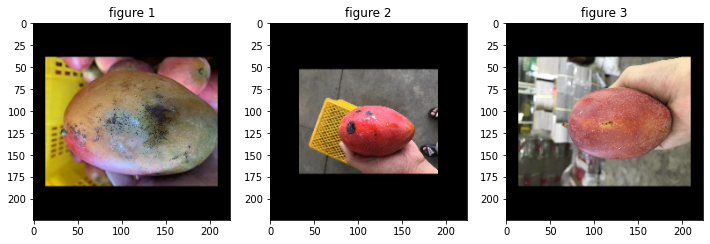

In [7]:
# from google.colab.patches import cv2_imshow
plt.figure(figsize=(12,8))
for i, img in enumerate(X_train[:3]):
#     print(f"第{i+1}張圖片:")
#     cv2_imshow(img*STD+MEAN)
#     img = img*STD+MEAN
#     img = img.astype(np.int32)
    ax = plt.subplot(1, 3, i+1)    
    plt.title(f"figure {i+1}")
    ax.imshow(img[:,:,::-1])

#     plt.imshow(img[:,:,::-1])

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1028)

In [9]:
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_val.shape", X_val.shape)
print("y_val.shape", y_val.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (5040, 224, 224, 3)
y_train.shape (5040, 3)
X_val.shape (560, 224, 224, 3)
y_val.shape (560, 3)
X_test.shape (800, 224, 224, 3)
y_test.shape (800, 3)


mean [55.49694383 60.2820865  82.53554147]

std [65.72940478 67.66902771 87.42390442]

In [10]:
# print("mean", X_train.mean(axis=(0,1,2)))
# print("std", np.sqrt(X_train.var(axis=(0,1,2))))

In [11]:
def pre_processing(X):
    X = X[:,:,:,::-1].transpose(0,3,1,2)
    X = torch.tensor(X.copy(), dtype=dtype)
    # X = torch.tensor(X, dtype=dtype)
    # f_norm = transforms.Normalize(
    #           mean=[55.49694383, 60.2820865, 82.53554147],
    #           std=[65.72940478, 67.66902771, 87.42390442])
    # X = f_norm(X)
    return X

class MangoDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        # self.X = pre_processing(X)
        self.X = X
        self.y = torch.tensor(y)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image =  self.X[idx]
        image = image[:,:,::-1].transpose(2,0,1)
        image = torch.tensor(image.copy(), dtype=dtype)
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [12]:
data_aug = [
  transforms.RandomCrop((200, 200)),
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  transforms.RandomAffine(degrees=50, translate=(0.15, 0.15)),
  transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
]

transform = transforms.Compose([
  transforms.RandomOrder(data_aug),
])

In [13]:
X_train.shape

(5040, 224, 224, 3)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

def fc_bc_relu_dropout(in_size, out_size, p=0.5):
    return nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.BatchNorm1d(out_size),
        nn.ReLU(),
        nn.Dropout(p=p),
    )

model = timm.create_model('inception_v4', pretrained=True, num_classes=3)
model_name = "inception_v4"

new_fc = torch.nn.Sequential(
    nn.Dropout(p=0.5),
    fc_bc_relu_dropout(2048, 1024, 0.5),
    fc_bc_relu_dropout(1024, 256, 0.5),
    nn.Linear(in_features=256, out_features=OUTPUT_CLASSES),
)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        print(m)

print('init weights [nn.Linear] layers:')
new_fc.apply(weights_init)

model.fc = new_fc

init weights [nn.Linear] layers:
Linear(in_features=2048, out_features=1024, bias=True)
Linear(in_features=1024, out_features=256, bias=True)
Linear(in_features=256, out_features=3, bias=True)


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [16]:
from torch.utils.data import DataLoader
from torch.utils.data import sampler
BATCH_SIZE = 64
train_dataset = MangoDataset(X_train, y_train, transform=transform)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = MangoDataset(X_val, y_val)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_dataset = MangoDataset(X_test, y_test)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [17]:
# freeze pretrain weight
for p in model.parameters():
  # p.requires_grad = False
  p.requires_grad = True

In [18]:
def count_parameters(model):
    trainable_p = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_p = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_p, non_trainable_p

print('# of parameters')
trainable_p, non_trainable_p = count_parameters(model)
print('trainable:     %15s' % format(trainable_p, ','))
print('non-trainable: %15s' % (format(non_trainable_p, ',')))

# of parameters
trainable:          43,511,334
non-trainable:               0


In [19]:
import torch.optim as optim

CE_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005, weight_decay=5e-3)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[10,20,40], gamma=0.9)

In [35]:
EPOCH = 50
history = History()

for epoch in range(EPOCH):  # loop over the dataset multiple times    
    n_batches = len(train_dataloader)
    print(f'Epoch {epoch+1}/{EPOCH}')
    pbar = tf.keras.utils.Progbar(target=n_batches)
    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device, dtype=dtype), data[1].to(device, dtype=dtype)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)

        loss = CE_loss(outputs, labels)
        loss.backward()
        
        optimizer.step()

        accuracy = calculate_accuracy(outputs, labels)
        loss = float(loss)
        
        pbar.update(i, values=[("train_loss", loss),
                    ("train_acc", accuracy)])
        
        history.batch_train(loss, accuracy)

    if scheduler.__module__ == 'torch.optim.lr_scheduler':
        scheduler.step()
        
    val_acc, val_loss, _ = validation(model, val_dataloader)            
    pbar.update(n_batches, values=[('val_loss', val_loss), ('val_acc', val_acc)])
    
    history.epoch_train(n_batches)
    history.epoch_val(val_loss, val_acc)

print('Finished Training')

Epoch 1/50
79/79 [==============================] - 80s 998ms/step - train_loss: 0.8071 - train_acc: 0.6246 - val_loss: 0.7564 - val_acc: 0.6518
Epoch 2/50
79/79 [==============================] - 79s 984ms/step - train_loss: 0.6723 - train_acc: 0.6917 - val_loss: 0.7151 - val_acc: 0.6893
Epoch 3/50
79/79 [==============================] - 79s 990ms/step - train_loss: 0.6086 - train_acc: 0.7311 - val_loss: 0.6545 - val_acc: 0.6964
Epoch 4/50
79/79 [==============================] - 79s 992ms/step - train_loss: 0.5834 - train_acc: 0.7427 - val_loss: 0.6028 - val_acc: 0.7196
Epoch 5/50
79/79 [==============================] - 79s 991ms/step - train_loss: 0.5596 - train_acc: 0.7517 - val_loss: 0.6021 - val_acc: 0.7214
Epoch 6/50
79/79 [==============================] - 79s 993ms/step - train_loss: 0.5546 - train_acc: 0.7559 - val_loss: 0.6186 - val_acc: 0.7321
Epoch 7/50
79/79 [==============================] - 79s 992ms/step - train_loss: 0.5297 - train_acc: 0.7619 - val_loss: 0.6129 - v

In [61]:
test_acc, test_loss, y_true_pred = validation(model, test_dataloader)
print(f"Test Accuracy = %.4f" % test_acc)

Test Accuracy = 0.7675


In [62]:
val_acc, val_loss, _ = validation(model, val_dataloader)
print(f"Validation Accuracy = %.4f" % val_acc)

Validation Accuracy = 0.7500


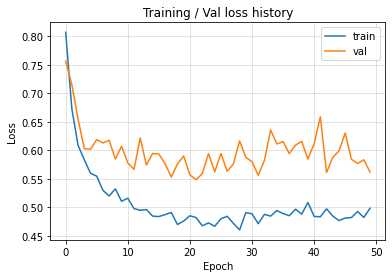

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.train_loss, label='train') 
plt.plot(history.val_loss, label='val') 
plt.title("Training / Val loss history")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

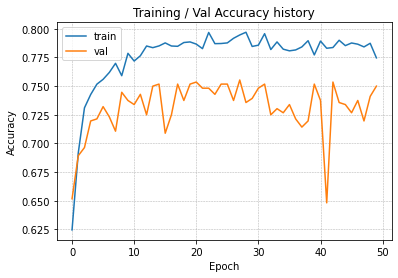

In [40]:
plt.plot(history.train_acc, label='train') 
plt.plot(history.val_acc, label='val') 
plt.title("Training / Val Accuracy history")
plt.xlabel("Epoch") # 這裡應該要是epoch
plt.ylabel("Accuracy")
plt.legend()
plt.grid(linestyle="--", linewidth=0.5)
plt.show()

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def make_confusion_matrix(y_true, y_score):
    cm = confusion_matrix(y_true, y_score)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C']) #
    disp.plot()
    return cm

In [52]:
y_true, y_pred = y_true_pred
y_true = torch.cat(([y_true[i] for i in range(len(y_true))]))
y_pred = torch.cat(([y_pred[i] for i in range(len(y_pred))]))
y_true = y_true.cpu()
y_pred = y_pred.cpu()

array([[231,  50,   7],
       [ 52, 214,  30],
       [ 12,  35, 169]], dtype=int64)

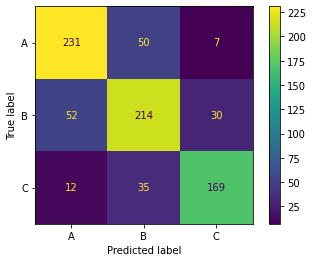

In [43]:
make_confusion_matrix(y_true, y_pred)

In [44]:
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred, digits=3, target_names=["A","B","C"]))

              precision    recall  f1-score   support

           A      0.783     0.802     0.792       288
           B      0.716     0.723     0.719       296
           C      0.820     0.782     0.801       216

    accuracy                          0.767       800
   macro avg      0.773     0.769     0.771       800
weighted avg      0.768     0.767     0.768       800



In [84]:
torch.save(model, 'model/inceptionV4_pretrain_aug_drop_reg_jitter.pt')

In [20]:
model = torch.load('model/inceptionV4_pretrain_aug_drop_reg_jitter.pt')
model = model.to(device)

In [21]:
all_scores = []
all_y_true = []
model.eval()  # set model to evaluation mode
with torch.no_grad():
    for x, y in test_dataloader:
        x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        y_true = y.to(device=device, dtype=dtype)
        score = model(x)
        all_scores.extend(score.tolist())
        all_y_true.extend(y_true.tolist())

all_y_true = np.array(all_y_true)

In [24]:
from sklearn.metrics import roc_curve, auc
def plot_roc(y_true,  y_score, n_classes, class_labels): #multiclass ROC curve
    """
    compute ROC curve and ROC area for each class in each fold

    """

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # plt.figure(figsize=(6,6))
    for i, label in enumerate(class_labels):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(label, roc_auc[i]))  # roc_auc_score

    plt.plot([0, 1], [0, 1], 'k--')
    # plt.grid()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.tight_layout()
    plt.show()

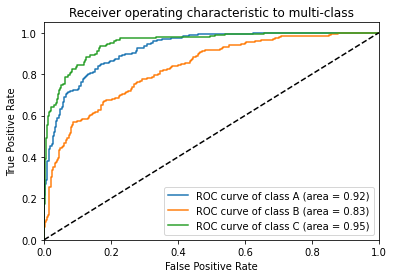

In [25]:
from scipy.special import softmax
y_score_softmax = softmax(all_scores)
plot_roc(all_y_true,  y_score_softmax, 3, ['A', 'B', 'C'])